# Tracking of a Spheroidal Colloid with Holopy

# Importations

In [1]:
import numpy as np

import imageio

import pandas as pd
import seaborn as sns
import scipy.stats as st

import os 
import sys
import copy
from tqdm import tqdm
import shutil

from multiprocessing import Pool

In [2]:
# Personal wrapper
import utilities

In [3]:
# Holopy
import holopy as hp
# Utilities
from holopy.core.io import load_average
from holopy.core.process import bg_correct, subimage, normalize, center_find
# Define Scatterers
from holopy.scattering import Sphere
from holopy.scattering.scatterer import Spheroid
# Theories
from holopy.scattering import Mie
from holopy.scattering.theory import Tmatrix
# from holopy.scattering.theory.dda import DDA
# Compute holograms and fit
from holopy.scattering import calc_holo
from holopy.inference import CmaStrategy
from holopy.inference import prior, NmpfitStrategy, ExactModel

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=600)

In [5]:
# os.environ.setdefault("OMPI_MCA_opal_cuda_support","true")
os.environ["OMPI_MCA_opal_cuda_support"] = "true" 

# Auxiliary Functions

In [6]:
# Adapted from pylorenzmie

def aziavgstd(data, center):
    '''Azimuthal average and standard deviation of data about center
    
    Parameters
    ----------
    data : array_like
        image data
    center : tuple
        (x_p, y_p) center of azimuthal average

    Returns
    -------
    avg : array_like
        One-dimensional azimuthal average of data about center
    std : array_like
        Standard deviation from the mean
    '''
    x_p, y_p = center
    ny, nx, _ = data.shape
    x = np.arange(nx) - x_p
    y = np.arange(ny) - y_p
    
    d = data.ravel()
    r = np.hypot.outer(y, x).astype(int).ravel()
    nr = np.bincount(r)
    avg = np.bincount(r, d) / nr
    std = np.sqrt(np.bincount(r, (d - avg[r])**2) / nr)
    rad = np.arange(len(avg))
    return rad, avg, std

# Inputs

In [7]:
# Optics & Camera
spacing = 0.05799
fps = 100

In [8]:
# Light
illum_polarization = (1, 0)
illum_wavelen = 0.532
medium_index = 1.33

In [9]:
# Path to an experimental video 
vid_path = '../test_tracking/chlamys/2_trimmed_1/2_Basler_acA1920-155um__22392621__20230511_191132584_trimmed_from_28_s_to_41_s.mp4'

In [10]:
# Open video
vid = utilities.video_reader(vid_path)

In [11]:
n_start = 0
n_stop = vid.get_length()
print(n_stop)

1303


In [12]:
# Experimental trajectory from Mie theory
mie_path = '../test_tracking/chlamys/2_trimmed_1/traj_rp_3p2295_np_1p4139_VideoName_2_Basler_acA1920-155um__22392621__20230511_191132584_trimmed_from_28_s_to_41_s.mat'

In [13]:
# Open trajectory
mie = utilities.open_xyz_mat(mie_path, version='1')
# Remove potential zeros at the end
mie = utilities.remove_end_zeros(mie)

No pb. No zero in raw data.


In [14]:
print('Lowest z = {} um'.format(min(mie[:,2] * 1e6)))

Lowest z = 141.5549340999804 um


# Theoretical Noisy Image

In [20]:
%%time

# Compute a Spheroid 

h = 100 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 0.5
da_p = - 0.1
n_p = 1.4

x_p = h//2*spacing
y_p = h//2*spacing
z_p = 2

theta1 = 5 * np.pi / 180
theta2 = 1
theta3 = 0

theory = Tmatrix()

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

holo_ideal = calc_holo(
    detector=detector, scatterer=spheroid, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory, 
)

CPU times: user 286 ms, sys: 786 µs, total: 287 ms
Wall time: 286 ms


In [21]:
# Noise the hologram 

noise = np.random.normal(loc=0.0, scale=np.std(holo_ideal.data)/2, size=np.shape(holo_ideal.data))

holo = copy.deepcopy(holo_ideal)
holo.data = holo_ideal + noise 

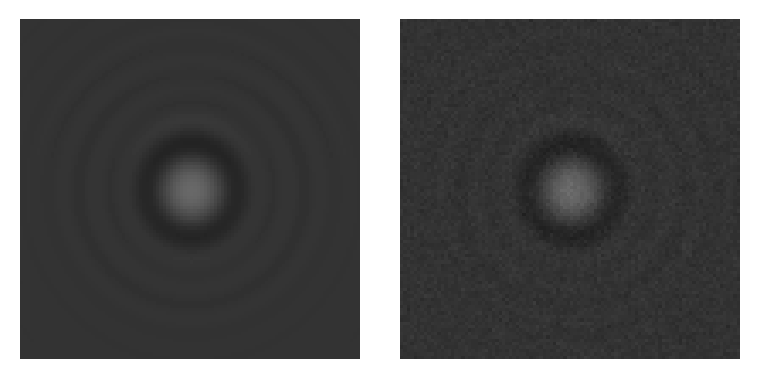

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))

vmin, vmax = 0, 5

axes[0].imshow(holo_ideal.data, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].imshow(holo.data, cmap='gray', vmin=vmin, vmax=vmax)

for i in range(len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Crop 

hc = h // 2
xc, yc = h//2, h//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

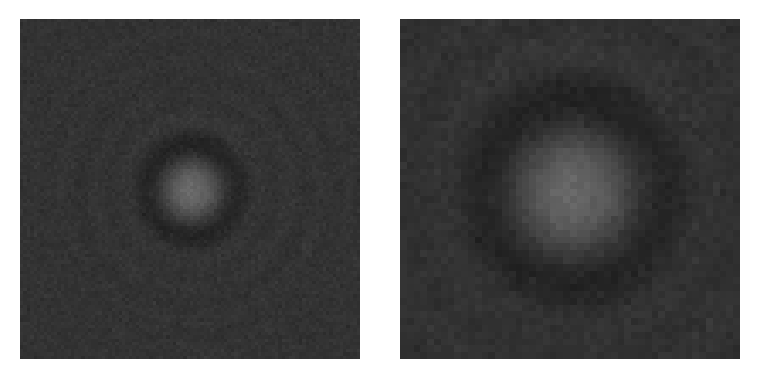

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))

vmin, vmax = 0, 5

axes[0].imshow(holo.data, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].imshow(holo_c.data, cmap='gray', vmin=vmin, vmax=vmax)

for i in range(len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [25]:
# Guess 

guess_scatterer = Spheroid(n=n_p-0.01, r=(a_p + 0.2, a_p + da_p - 0.1), center=(x_p, y_p, z_p), rotation=(theta1+3/180*np.pi, theta2-10/180*np.pi, theta3+1/180*np.pi))

In [26]:
# Define the fitting strategy

percent_px = 0.2

fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(percent_px * hc ** 2)

# fit_strategy = CmaStrategy(popsize=50, parallel=None)
# fit_strategy.npixels = int(percent_px * hc ** 2)
# fit_strategy.resample_pixels = True
# fit_strategy.parallel = 10 #'mpi'
# fit_strategy.seed = 1000

In [27]:
# Which parameters 
parameters_to_fit = ['center', 'r', 'n', 'rotation']

In [28]:
%%time 

# Fit
fit_result = hp.fit(holo_c, guess_scatterer, strategy=fit_strategy, parameters=parameters_to_fit)

: 

In [24]:
holo_f = fit_result.hologram

{'n': 1.4191878570034928, 'r.0': 1.0147372886117738, 'r.1': 0.3962269271573597, 'rotation.0': 0.17095471720429678, 'rotation.1': 0.9152436884836603, 'rotation.2': 0.02275279699421689, 'x': 5.79675156503865, 'y': 5.790469084063226, 'z': 15.011448359052787, 'alpha': 0.9766125391591389}


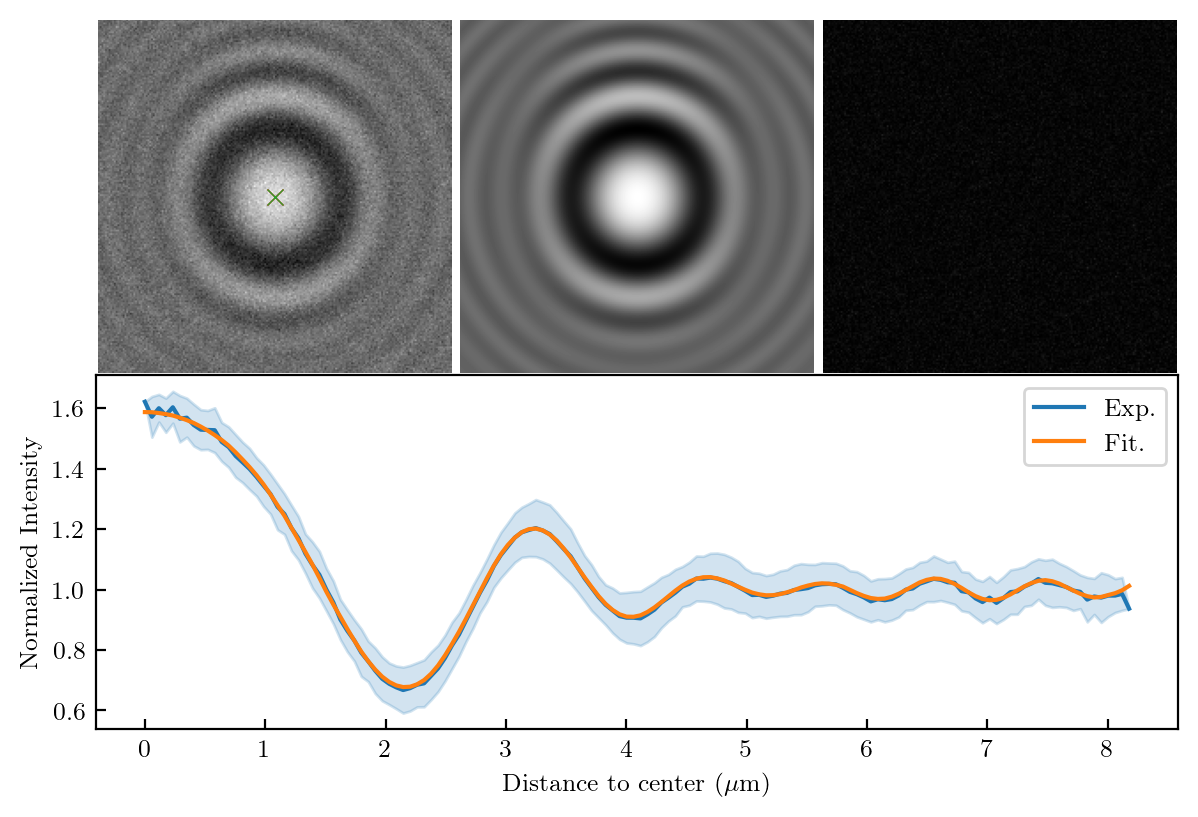

In [25]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')
ax1.plot(fit_result.parameters['x'] / spacing, fit_result.parameters['y'] / spacing, 'x', mec='tab:green')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

# Several Theoretical Images

In [47]:
# Auxiliary function: compute an hologram corresponding to a spheroidal colloid

def compute_a_spheroid(position, a_p=a_p, da_p=da_p, n_p=n_p, detector=detector, theory=Tmatrix(), noise=1/2):
    x_p, y_p, z_p, theta1, theta2, theta3 = position
    spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))
    holo_ideal = calc_holo(
        detector=detector, scatterer=spheroid, 
        medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
        theory=theory, 
    )
    # Noise
    noise = np.random.normal(loc=0.0, scale=np.std(holo_ideal.data)*noise, size=np.shape(holo_ideal.data))
    holo = copy.deepcopy(holo_ideal)
    holo.data = holo_ideal + noise 
    # print('Done')
    return holo

In [48]:
# Initiate positions of the theoretical holograms

positions = [np.array([x_p, y_p, z_p, theta1, theta2, theta3])] * 100
for i in range(len(positions)):
    random = np.random.normal(loc=np.array([x_p, y_p, z_p, theta1, theta2, theta3]), scale=np.array([0, 0, 0.1] + [1*np.pi/180] * 2 + [0]), size=6)
    positions[i] = random

In [51]:
# Compute several holograms to be fitted 

with Pool(20) as pool:
    results = pool.map(compute_a_spheroid, positions)

In [52]:
# Save holograms

path_holograms = './noisy_holograms/'
try:
    os.mkdir(path_holograms)
except FileExistsError:
    shutil.rmtree(path_holograms)
    os.mkdir(path_holograms)

for i in range(len(results)):
    hp.save(path_holograms + str(i), results[i])

# Convert positions to a panda dataframe and save it 
positions = np.array(positions)
positions = pd.DataFrame(positions)
positions.to_pickle(path_holograms + 'positions')

In [54]:
positions.head()

,0,1,2,3,4,5
0,5.799,5.799,14.964528,0.107670,0.985953,0.0
1,5.799,5.799,14.914573,0.113684,1.015471,0.0
2,5.799,5.799,15.039716,0.071404,0.990374,0.0
3,5.799,5.799,14.986728,0.066956,1.017397,0.0
4,5.799,5.799,15.018321,0.080505,1.014278,0.0
